## CODE TO PERFORM VEHICLE DETECTION USING HOG/SVM


In [ ]:
# Dataset source:
# https://github.com/udacity/CarND-Vehicle-Detection
# http://www.gti.ssr.upm.es/data/Vehicle_database.html
# http://www.cvlibs.net/datasets/kitti/


# DISPLAY IMAGES

In [2]:
import cv2
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog


In [ ]:
#import training dataset of vehicles/non-vehicles
import glob
car = glob.glob('data/car/**/*.png')
no_car = glob.glob('data/no car/**/*.png')


In [1]:
from google.colab import files
uploaded = files.upload()

Saving data.zip to data.zip


In [10]:
import zipfile
with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [14]:
import glob

# Replace 'data/car/' and 'data/no car/' with the actual folder paths
vehicles = glob.glob('/content/data/vehicles/**/*.png', recursive=True)
nonvehicles = glob.glob('/content/data/non-vehicles/**/*.png', recursive=True)

In [15]:
len(vehicles)

8792

In [16]:
len(nonvehicles)

8968

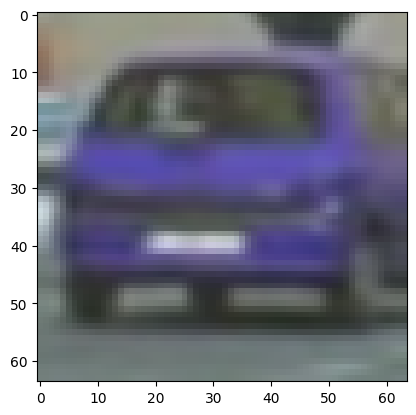

In [17]:
image_color = cv2.imread(vehicles[300])
plt.imshow(image_color)

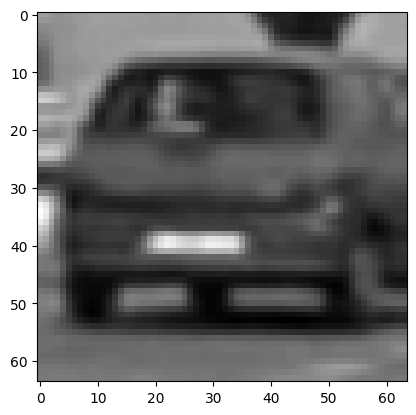

In [18]:
image_gray = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)
plt.imshow(image_gray, cmap = 'gray')

# GET HOG FEATURES

In [19]:

features, hog_image = hog(image_gray,
                          orientations = 11,
                          pixels_per_cell = (16, 16),
                          cells_per_block = (2, 2),
                          transform_sqrt = False,
                          visualize = True,
                          feature_vector = True)

features.shape

(396,)

In [20]:
hog_image.shape

(64, 64)

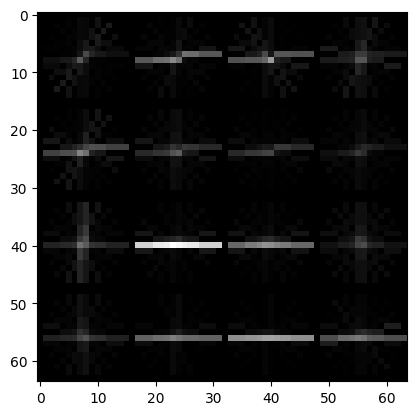

In [21]:
plt.imshow(hog_image, cmap = 'gray')


# HOG FEATURE EXTRACTION AND TRAINING DATASET CREATION

In [22]:
car_hog_accum = []

for i in vehicles:
    image_color = mpimg.imread(i)
    image_gray  = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)

    car_hog_feature, car_hog_img = hog(image_color[:,:,0],
                                    orientations = 11,
                                    pixels_per_cell = (16, 16),
                                    cells_per_block = (2, 2),
                                    transform_sqrt = False,
                                    visualize = True,
                                    feature_vector = True)

    car_hog_accum.append(car_hog_feature)


In [23]:
X_car = np.vstack(car_hog_accum).astype(np.float64)
y_car = np.ones(len(X_car))

In [24]:
X_car.shape

(8792, 396)

In [25]:
y_car.shape

(8792,)

In [26]:
y_car

array([1., 1., 1., ..., 1., 1., 1.])

In [28]:
nocar_hog_accum = []

for i in nonvehicles:
    image_color = mpimg.imread(i)
    image_gray  = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)

    nocar_hog_feature, car_hog_img = hog(image_color[:,:,0],
                                    orientations = 11,
                                    pixels_per_cell = (16, 16),
                                    cells_per_block = (2, 2),
                                    transform_sqrt = False,
                                    visualize = True,
                                    feature_vector = True)

    nocar_hog_accum.append(nocar_hog_feature)


In [29]:
X_nocar = np.vstack(nocar_hog_accum).astype(np.float64)
y_nocar = np.zeros(len(X_nocar))

In [30]:
X_nocar.shape

(8968, 396)

In [31]:
y_nocar.shape

(8968,)

In [32]:
X = np.vstack((X_car, X_nocar))
X.shape

(17760, 396)

In [33]:
y = np.hstack((y_car, y_nocar))
y.shape

(17760,)

# SVM MODEL CLASSIFIER TRAINING

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)


In [35]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report,confusion_matrix
svc_model = LinearSVC()
svc_model.fit(X_train,y_train)

LinearSVC()

<Axes: >

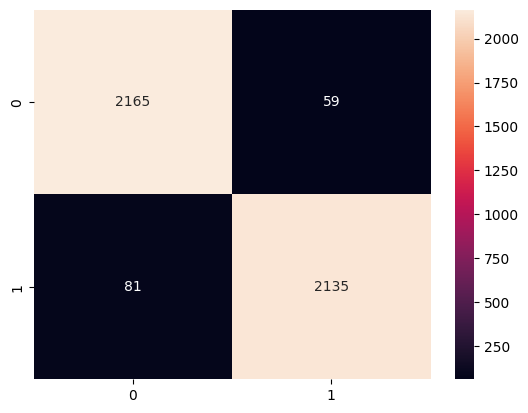

In [36]:
y_predict = svc_model.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(y_test, y_predict)

sns.heatmap(cm, annot=True, fmt="d")

In [37]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97      2224
         1.0       0.97      0.96      0.97      2216

    accuracy                           0.97      4440
   macro avg       0.97      0.97      0.97      4440
weighted avg       0.97      0.97      0.97      4440



In [38]:
Model_prediction = svc_model.predict(X_test[0:50])
Model_prediction


array([0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1.,
       0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.])

In [39]:
Model_TrueLabel = y_test[0:50]
Model_TrueLabel

array([0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1.,
       0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.])

# IMPROVE THE MODEL

In [40]:
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']}

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=4)
grid.fit(X_train,y_train)
grid.best_params_
grid.best_estimator_


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.967 total time=  16.7s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.973 total time=  17.3s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.969 total time=  16.5s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.962 total time=  16.9s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.961 total time=  17.9s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.960 total time=  12.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.971 total time=  12.1s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.968 total time=  11.5s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.962 total time=  11.8s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.959 total time=  11.5s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.931 total time=  25.9s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf;

SVC(C=10, gamma=1)

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2224
         1.0       0.99      0.99      0.99      2216

    accuracy                           0.99      4440
   macro avg       0.99      0.99      0.99      4440
weighted avg       0.99      0.99      0.99      4440



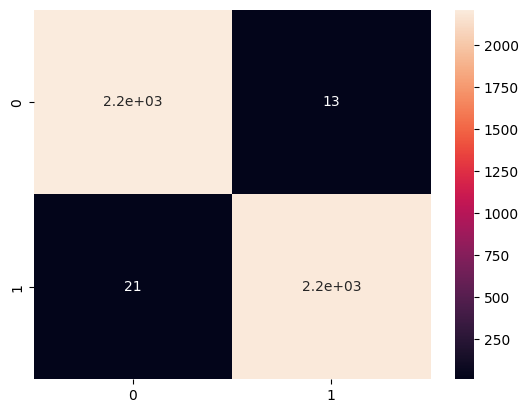

In [41]:
grid_predictions = grid.predict(X_test)
cm = confusion_matrix(y_test, grid_predictions)
sns.heatmap(cm, annot=True)
print(classification_report(y_test,grid_predictions))

# TEST THE MODEL (FIND CARS)!

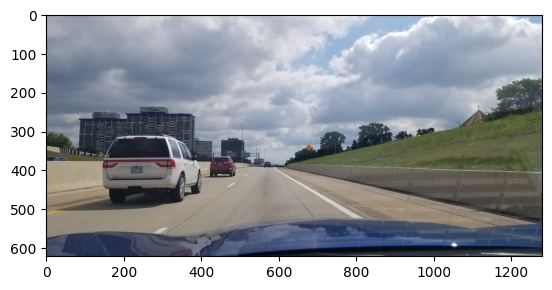

In [43]:
test_image = mpimg.imread('my_test_image_resized.jpg')
plt.imshow(test_image)
test_image = test_image.astype(np.float32)/255

(180, 1280, 3)

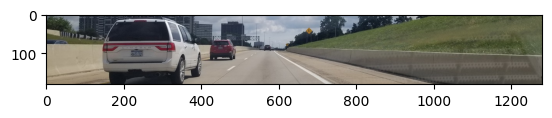

In [44]:
h_start = 300
h_stop = 480

pixels_in_cell = 16
HOG_orientations = 11
cells_in_block = 2
cells_in_step = 3


masked_region = test_image[h_start:h_stop,:,:]
plt.imshow(masked_region)
masked_region.shape


In [45]:
resizing_factor = 2
masked_region_shape = masked_region.shape
L = masked_region_shape[1]/resizing_factor
W = masked_region_shape[0]/resizing_factor

(90, 640, 3)


<ipython-input-46-b34d44b65044>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  masked_region_resized = cv2.resize(masked_region, (np.int(L), np.int(W)))


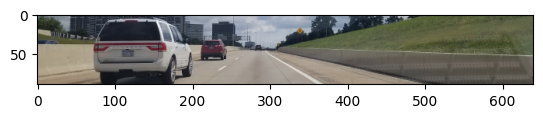

In [46]:
masked_region_resized = cv2.resize(masked_region, (np.int(L), np.int(W)))
masked_region_resized_R = masked_region_resized[:,:,0]

print(masked_region_resized.shape)
plt.imshow(masked_region_resized)


In [47]:

print(masked_region_resized_R.shape)
masked_region_hog_feature_all, hog_img = hog(masked_region_resized_R, orientations = 11, pixels_per_cell = (16, 16), cells_per_block = (2, 2), transform_sqrt = False, visualize = True, feature_vector = False)


(90, 640)


In [48]:
n_blocks_x = (masked_region_resized_R.shape[1] // pixels_in_cell)+1
n_blocks_y = (masked_region_resized_R.shape[0] // pixels_in_cell)+1

#nfeat_per_block = orientations * cells_in_block **2
blocks_in_window = (64 // pixels_in_cell)-1

steps_x = (n_blocks_x - blocks_in_window) // cells_in_step
steps_y = (n_blocks_y - blocks_in_window) // cells_in_step

rectangles_found = []

for xb in range(steps_x):
    for yb in range(steps_y):
        y_position = yb*cells_in_step
        x_position = xb*cells_in_step

        hog_feat_sample = masked_region_hog_feature_all[y_position : y_position + blocks_in_window, x_position : x_position + blocks_in_window].ravel()
        x_left = x_position * pixels_in_cell
        y_top = y_position * pixels_in_cell
        print(hog_feat_sample.shape)

        # predict using trained SVM
        test_prediction = svc_model.predict(hog_feat_sample.reshape(1,-1))
        # test_prediction = grid.predict(hog_feat_sample.reshape(1,-1))

        if test_prediction == 1:
            rectangle_x_left = np.int(x_left * resizing_factor)
            rectangle_y_top = np.int(y_top * resizing_factor)
            window_dim = np.int(64 * resizing_factor)
            rectangles_found.append(((rectangle_x_left, rectangle_y_top + h_start),(rectangle_x_left + window_dim, rectangle_y_top + window_dim + h_start)))


(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)


<ipython-input-48-f573e59c201e>:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rectangle_x_left = np.int(x_left * resizing_factor)
<ipython-input-48-f573e59c201e>:28: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated i

In [49]:
rectangles_found

[((192, 300), (320, 428)),
 ((384, 300), (512, 428)),
 ((672, 300), (800, 428)),
 ((768, 300), (896, 428))]

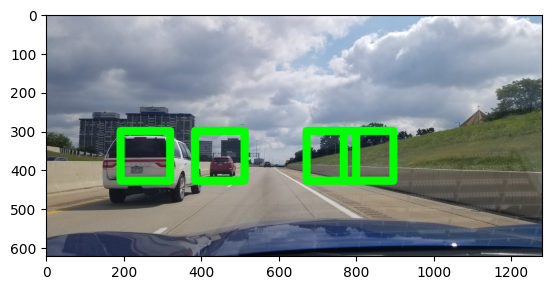

In [50]:
Image_with_Rectangles_Drawn = np.copy(test_image)

for rectangle in rectangles_found:
    cv2.rectangle(Image_with_Rectangles_Drawn, rectangle[0], rectangle[1], (0, 255, 0), 20)

plt.imshow(Image_with_Rectangles_Drawn)
